In [1]:
import copulagp.bvcopula as bvcopula

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

# Model fitting and calculations

CPU times: user 3min 36s, sys: 2.8 s, total: 3min 38s
Wall time: 5min 55s
-0.024705443531274796
CPU times: user 1min 11s, sys: 153 ms, total: 1min 11s
Wall time: 1min 40s
-0.026203863322734833


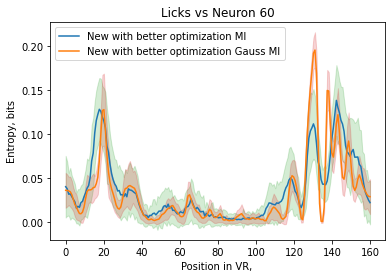

In [2]:
n1,n2 = 3,63 # Index -2 = Licks, 60 = Neuron 60

import torch
device='cuda:0'
with open(f"../../plos_fig5_data/ex_{n1}_{n2}_serialized.pkl","rb") as f:
    data = pkl.load(f)
train_x = torch.tensor(data['X'],device=device).float()
train_y = torch.tensor(data['Y'],device=device).float()


likelihoods = [bvcopula.FrankCopula_Likelihood(),bvcopula.ClaytonCopula_Likelihood(rotation='0°'),bvcopula.GumbelCopula_Likelihood(rotation='270°')] #[bvcopula.GaussianCopula_Likelihood()]
%time waic, model = bvcopula.infer(likelihoods,train_x,train_y,device=device,prior_rbf_length=0.5,output_loss='loss.png')
print(waic)

test_x = torch.linspace(0,1,200,device=device).float()
MI = np.zeros((100,200))
for i in range(100):
    f = model.gp_model(test_x).rsample(torch.Size([1])) # sample from a GP
    copula = model.likelihood.get_copula(f) # initialize a copula, parameterized by that GP sample
    MI[i] = copula.entropy(sem_tol=0.01, mc_size=1000).cpu().numpy()

likelihoods = [bvcopula.GaussianCopula_Likelihood()]
%time waic, gauss_model = bvcopula.infer(likelihoods,train_x,train_y,device=device,prior_rbf_length=0.5,output_loss='loss.png')
print(waic)

gauss_MI = np.zeros((100,200))
for i in range(100):
    f = gauss_model.gp_model(test_x).rsample(torch.Size([1])) # sample from a GP
    copula = gauss_model.likelihood.get_copula(f) # initialize a copula, parameterized by that GP sample
    gauss_MI[i] = copula.entropy(sem_tol=0.01, mc_size=1000).cpu().numpy()
    
# f = model.gp_model(test_x).mean # sample from a GP
# copula = model.likelihood.get_copula(f) # initialize a copula, parameterized by that GP sample
# MI = copula.entropy(sem_tol=0.01, mc_size=1000)
# copula = model.marginalize(test_x)
# %time gauss_MI = copula.entropy(sem_tol=0.001, mc_size=1000)

plt.title('Licks vs Neuron 60')
# plt.plot(np.linspace(0,160,200),data['MI'][1], label='Old MI')
# plt.plot(np.linspace(0,160,200),data['gauss_MI'][1], label='Old Gauss MI')
plt.plot(np.linspace(0,160,200),-MI.mean(0), label='New with better optimization MI')
plt.fill_between(np.linspace(0,160,200),-MI.mean(0)-MI.std(0),-MI.mean(0)+MI.std(0),alpha=0.2,color='C2')
plt.plot(np.linspace(0,160,200),-gauss_MI.mean(0), label='New with better optimization Gauss MI')
plt.fill_between(np.linspace(0,160,200),-gauss_MI.mean(0)-gauss_MI.std(0),-gauss_MI.mean(0)+gauss_MI.std(0),alpha=0.2,color='C3')
plt.ylabel('Entropy, bits')
plt.xlabel('Position in VR, ')
plt.legend()

In [3]:
data['MI'] = MI
data['gauss_MI'] = gauss_MI
with open(f"/home/nina/CopulaGP/plos_fig5_data/ex_{n1}_{n2}_serialized_rep.pkl","wb") as f:
    pkl.dump(data,f)

In [4]:
import torch
import copulagp.bvcopula as bvcopula

n1, n2 = -2,60

device = "cuda:0"
with open(f"../../plos_fig5_data/ex_{n1}_{n2}_serialized.pkl","rb") as f:
    data = pkl.load(f)
train_x = torch.tensor(data['X'],device=device).float()
train_y = torch.tensor(data['Y'],device=device).float()

In [5]:
from torch import Tensor
def _generate_test_samples(model: bvcopula.Pair_CopulaGP, test_x: Tensor) -> Tensor:
    
    with torch.no_grad():
        output = model.gp_model(test_x)

    #generate some samples
    model.gp_model.eval()
    with torch.no_grad(), num_likelihood_samples(1):
        gplink = model.gplink
        likelihoods = model.likelihood.likelihoods
        copulas = [lik.copula for lik in likelihoods]
        rotations = [lik.rotation for lik in likelihoods]
        thetas, mixes = gplink(output.mean)
        test_y = model.likelihood.copula(thetas,mixes,
                    copulas, rotations=rotations).rsample()
        Y_sim = test_y.cpu().detach().numpy()

    return Y_sim

def _get_pearson(X: Tensor, Y: Tensor):
    from scipy.stats import pearsonr

    X = X.squeeze()
    assert np.isclose(X.max(),1.0,atol=1e-4)
    assert np.isclose(X.min(),0.0,atol=1e-4)
    N = int(160/2.5)
    x = np.linspace(0,1,N)
    p = np.empty(N)

    for b in range(N):
        dat = Y[(X>b*(1./N)) & (X<(b+1)*(1./N))]
        if len(dat)>1:
            p[b] = pearsonr(*dat.T)[0]
        
    p = np.convolve(np.array(p), np.ones((4,))/4, mode='valid')    

    return np.stack([x[2:-1]*160,p])

NameError: name 'utils' is not defined

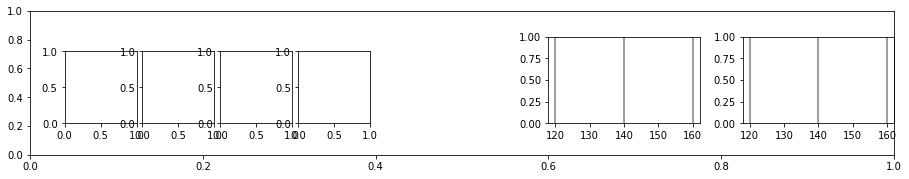

In [6]:
name1, name2 = f"Neuron {data['n1']}", f"Neuron {data['n2']}"
    
name1 = 'Licks'

# visualize the result
from copulagp.utils import plot_conf as conf2
from gpytorch.settings import num_likelihood_samples
X = data['X']
Y = data['Y']
fig = plt.figure(figsize=(12,2))

ax0 = fig.add_axes([0,0,1,1])

b_mrg = 0.22
top_axes = (fig.add_axes([0.6, b_mrg, 0.175, 0.6]),
            fig.add_axes([0.825, b_mrg,0.175, 0.6]))
bottom_axes = np.array([fig.add_axes([0.04,b_mrg,0.5/6,0.5]),
                        fig.add_axes([0.13,b_mrg,0.5/6,0.5]),
                        fig.add_axes([0.22,b_mrg,0.5/6,0.5]),
                        fig.add_axes([0.31,b_mrg,0.5/6,0.5])])

for a in top_axes:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)    

# define test set (optionally on GPU)
NSamp = X.shape[0] #by defauls generate as many samples as in training set
testX = np.linspace(0,1,NSamp)
test_x = torch.tensor(testX).float().to(device=device)

Y_sim = _generate_test_samples(model, test_x)

utils.Plot_MixModel_Param_MCMC(top_axes,model,test_x,testX*160,rho=_get_pearson(X,Y),title='')
top_axes[0].set_title(r'Copula parameters $\theta$')
top_axes[1].set_title('Mixing parameters $\phi$')
top_axes[0].legend(loc=(-1.1,0.1))
top_axes[1].legend().set_visible(False)
# top_axes[0].set_ylabel(r"$\theta\_{normalized}$",labelpad=-1)

bottom_axes[0].set_ylabel(name2)
bottom_axes[0].set_xlabel(name1)

interval_ends = [0,60,120,140,160]
# fig.text(0.005,0.91,"A",fontweight="bold",fontsize=14)
# fig.text(0.040,0.91,"Inter-neuronal noise correlations",fontsize=14)
fig.text(0.005,0.91,"B",fontweight="bold",fontsize=14)
fig.text(0.040,0.91,"Behavioral modulations",fontsize=14)
utils.Plot_Copula_Density(bottom_axes, testX.squeeze()*160, Y_sim.squeeze(), interval_ends, shade=True)
utils.Plot_Copula_Density(bottom_axes, X.squeeze()*160, Y, interval_ends, shade=False, color='#073763ff')
for b in bottom_axes[1:]:
    b.set_yticks([])
bottom_axes[0].set_yticks([0,1])
    
plt.subplots_adjust(wspace=0.5)
fig.savefig(f"{home}/results/example2.pdf")

In [ ]:
# visualize the result
fig = plt.figure(figsize=(5, 2))

bottom_axes = np.array([fig.add_axes([0,0,0.2,0.5]),
               fig.add_axes([0.25,0,0.2,0.5]),
               fig.add_axes([0.5,0,0.2,0.5]),
               fig.add_axes([0.75,0,0.2,0.5])])

plt.subplots_adjust(hspace=0.5)

bottom_axes[0].set_ylabel(name2)
bottom_axes[0].set_xlabel(name1)

interval_ends = [0,60,120,140,160]
utils.Plot_Copula_Density(bottom_axes, data['Xs'].squeeze()*160, data['Ys'].squeeze(), 
                          interval_ends, shade=True)
utils.Plot_Copula_Density(bottom_axes, data['X'].squeeze()*160, data['Y'], 
                          interval_ends, shade=False, color='#073763ff')

plt.subplots_adjust(wspace=0.5)

# R^2

In [ ]:
ints = np.array([0,60,120,140,160])/160
R = []
N, M = 20, 100
mesh = torch.stack(torch.meshgrid([torch.linspace(0.,1.,M+2)[1:-1], 
                                   torch.linspace(0.,1.,N+2)[1:-1]]),axis=-1).reshape(-1,2).to(device)
for i in range(len(ints)-1):
    mask = (data['X']>ints[i]) & (data['X']<ints[i+1])
    S = data['Y'][mask]
    u_cdf = np.cumsum(np.histogram2d(*S.T,bins=[M+1,N])[0],axis=0)
    ecdf = u_cdf[:-1] / u_cdf.max(axis=0)
    # plt.imshow(ecdf)
    mean = data['X'][mask].mean()
    test_x = (torch.ones(M*N)*mean).float().cuda(device=device)
    with torch.no_grad():
        f = model.gp_model(test_x).mean
        copula = model.likelihood.get_copula(f)
    ccdf = copula.ccdf(mesh).detach().cpu().numpy().reshape(M,N)
    # plt.imshow(ccdf)
    # base = np.repeat((np.linspace(0,1,N+2)[1:-1]).reshape(-1,1),N,axis=1)
    var_exp = 1 - ((ecdf-ccdf)**2).sum(axis=0)/((ecdf-0.5)**2).sum(axis=0)
    R.append(var_exp.mean())
# plt.plot(np.linspace(0,1,N+2)[1:-1])
# plt.plot(ecdf[:,-4])
# plt.plot(ccdf[:,-4])
# plt.plot(base[:,-4])
R

In [ ]:
R

In [ ]:
# pre-computed with the script above
[R1,R2] = [[0.9860019722068722, 0.9729762509342, 0.9448647468109408, 0.9821123175158591],
 [0.9885824997929535,
  0.983195342980131,
  0.9834448477631075,
  0.9790247773014025]]